In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Open SOS Measurement Dataset, extract measurements

In [2]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)


alt.Chart(
    tidy_df[(tidy_df.time < '20221220') & (tidy_df["measurement"].isin(['w','v','u']))].query("height == 1")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color("measurement:N"),
    alt.Facet('tower:N'),
).properties(width=300, height=300)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Add absolute humidity measurements by converting hygrometer measurements

In [3]:
any(tidy_df[tidy_df.measurement=='mixing ratio'].height.unique() == 1)

True

In [4]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

# Calibrate gas analyzer measurements

## Assume that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [5]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [6]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [7]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

variable tower  height     value     truth    offset
0    h2o_10m_c     c    10.0  2.128948  2.080217  0.048731
1    h2o_10m_d     d    10.0  1.264312  2.080217 -0.815905
2   h2o_10m_ue    ue    10.0  1.091568  2.080217 -0.988648
3   h2o_10m_uw    uw    10.0  1.608586  2.080217 -0.471630
4    h2o_15m_c     c    15.0  1.954592  2.065882 -0.111290
5     h2o_1m_c     c     1.0  2.264087  2.113118  0.150968
6     h2o_1m_d     d     1.0  1.700445  2.113118 -0.412673
7    h2o_1m_ue    ue     1.0  1.310203  2.113118 -0.802916
8    h2o_1m_uw    uw     1.0  1.502313  2.113118 -0.610806
9    h2o_20m_c     c    20.0  0.934247  2.056363 -1.122116
10    h2o_2m_c     c     2.0  1.975427  2.116022 -0.140595
11    h2o_3m_c     c     3.0  1.830270  2.118387 -0.288117
12    h2o_3m_d     d     3.0  1.734805  2.118387 -0.383582
13   h2o_3m_ue    ue     3.0  1.892941  2.118387 -0.225447
14   h2o_3m_uw    uw     3.0  1.971927  2.118387 -0.146460
15    h2o_5m_c     c     5.0  1.952607  2.091596 -0.138989

## Update dataset with corrections

In [8]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

time    variable     value  height tower  \
94      2022-11-30 00:00:00   h2o_3m_uw  0.724031     3.0    uw   
189     2022-11-30 00:00:00    h2o_3m_c  0.913812     3.0     c   
219     2022-11-30 00:00:00   h2o_3m_ue  0.565408     3.0    ue   
221     2022-11-30 00:00:00  h2o_10m_ue  0.015322    10.0    ue   
337     2022-11-30 00:00:00   h2o_1m_uw  0.054356     1.0    uw   
...                     ...         ...       ...     ...   ...   
6656716 2023-05-09 17:30:00    h2o_3m_d  2.589736     3.0     d   
6656738 2023-05-09 17:30:00   h2o_10m_d  1.786908    10.0     d   
6656748 2023-05-09 17:30:00    h2o_3m_c  2.471905     3.0     c   
6656850 2023-05-09 17:30:00   h2o_1m_uw       NaN     1.0    uw   
6657107 2023-05-09 17:30:00   h2o_10m_c  2.466102    10.0     c   

                 measurement  
94       Water vapor density  
189      Water vapor density  
219      Water vapor density  
221      Water vapor density  
337      Water vapor density  
...                      ...  
6656716  Water vapor density  
6656738  Water vapor density  
6656748  Water vapor density  
6656850  Water vapor density  
6657107  Water vapor density  

[92568 rows x 6 columns]

In [9]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [11]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [12]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]

alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/796244343.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Create wide df

In [13]:
vars = [
    'dir_1m_ue', 'u_h2o__1m_ue', 'v_h2o__1m_ue', 'w_h2o__1m_ue',     'u_1m_ue',  'v_1m_ue',  'w_1m_ue', 
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_1m_uw', 'u_h2o__1m_uw', 'v_h2o__1m_uw', 'w_h2o__1m_uw',     'u_1m_uw',  'v_1m_uw',  'w_1m_uw', 
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_1m_d', 'u_h2o__1m_d', 'v_h2o__1m_d', 'w_h2o__1m_d',        'u_1m_d',   'v_1m_d',   'w_1m_d',  
    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_1m_c', 'u_h2o__1m_c', 'v_h2o__1m_c', 'w_h2o__1m_c',        'u_1m_c',   'v_1m_c',   'w_1m_c',   'specifichumidity_1m_c',    'airdensity_1m_c',
    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 
    # 'T_12m_c',
      'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')


assert len(vars) == len(pivot_df.columns.unique())

# Identify categories for timestamps

In [14]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [15]:
import xarray as xr
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create table with instrument location info 

We use a file with theodolite/GPS readings provided by NCAR. 

In [16]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

# Create tables

## Wind field measurements

In [17]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin([1,3,10])]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-30 00:00:00  0.8442 -2.0019 -0.0388  0.8241 -1.8621 -0.0258  0.7621   
2022-11-30 00:30:00 -0.2592 -1.0267 -0.0255 -0.1717 -1.0263 -0.0297 -0.3245   
2022-11-30 01:00:00  0.2995 -1.1331 -0.0291  0.3493 -1.0744 -0.0199  0.2869   
2022-11-30 01:30:00  0.6549 -1.6004 -0.0338  0.6431 -1.4701 -0.0231  0.6043   
2022-11-30 02:00:00 -0.2904 -0.8675 -0.0303 -0.2469 -0.8933 -0.0251 -0.3630   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-30 00:00:00 -1.9373 -0.0491  0.3113  ... -0.0823  2.5216 -2.1892   
2022-11-30 00:30:00 -1.0934 -0.0513 -0.2333  ... -0.0342 -0.0728 -0.8173   
2022-11-30 01:00:00 -1.1269 -0.0483  0.0885  ... -0.0566  0.6077 -0.6620   
2022-11-30 01:30:00 -1.5538 -0.0509  0.1304  ... -0.0922  1.8981 -1.5050   
2022-11-30 02:00:00 -0.9753 -0.0559 -0.2954  ... -0.0281 -0.0230 -0.5847   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-30 00:00:00 -0.0065  2.2063 -2.3716  0.0385  1.9062 -2.7111 -0.0001  
2022-11-30 00:30:00  0.0189 -0.2529 -0.7708  0.0288 -0.2268 -0.7774 -0.0121  
2022-11-30 01:00:00  0.0028  0.4626 -0.7354  0.0229  0.4762 -0.8680 -0.0210  
2022-11-30 01:30:00 -0.0322  1.7291 -1.6854 -0.0059  1.4609 -2.0032 -0.0751  
2022-11-30 02:00:00  0.0230 -0.1797 -0.4797  0.0546 -0.0708 -0.5148 -0.0342  

[5 rows x 36 columns]

## Turbulent water vapor flux measurements

In [18]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin([1,3,10])]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-30 00:00:00 -0.0023  0.0060 -0.0008 -0.0013  0.0067 -0.0008  0.0005   
2022-11-30 00:30:00 -0.0122  0.0142 -0.0007 -0.0032  0.0118 -0.0005 -0.0000   
2022-11-30 01:00:00 -0.0024  0.0032 -0.0003  0.0033  0.0017 -0.0001 -0.0000   
2022-11-30 01:30:00 -0.0007 -0.0005 -0.0004  0.0026 -0.0012 -0.0003  0.0004   
2022-11-30 02:00:00 -0.0013  0.0059 -0.0004 -0.0003  0.0132 -0.0001  0.0005   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-30 00:00:00 -0.0009  0.0000  0.0082  ...  0.0011 -0.0254  0.0075   
2022-11-30 00:30:00  0.0000  0.0000  0.0042  ...  0.0005 -0.0213  0.0102   
2022-11-30 01:00:00 -0.0000 -0.0000  0.0056  ... -0.0007 -0.0098  0.0011   
2022-11-30 01:30:00 -0.0002 -0.0001 -0.0001  ...  0.0004 -0.0119  0.0032   
2022-11-30 02:00:00 -0.0001 -0.0001 -0.0005  ... -0.0003 -0.0088  0.0135   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-30 00:00:00  0.0009 -0.0040  0.0051 -0.0003 -0.0298  0.0238  0.0001  
2022-11-30 00:30:00  0.0005 -0.0119  0.0123  0.0005 -0.0179  0.0177  0.0005  
2022-11-30 01:00:00 -0.0002 -0.0048  0.0034  0.0003 -0.0110  0.0028  0.0007  
2022-11-30 01:30:00  0.0006 -0.0108  0.0058 -0.0006 -0.0108  0.0062 -0.0002  
2022-11-30 02:00:00 -0.0004  0.0060  0.0244 -0.0002 -0.0002  0.0046 -0.0013  

[5 rows x 36 columns]

## Humidity measurements

In [19]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df[abs_hum_field_df.height == 1]

time   variable     value  height tower  \
561     2022-11-30 00:00:00   h2o_1m_c  0.635500     1.0     c   
1168    2022-11-30 00:30:00   h2o_1m_c  0.734797     1.0     c   
2259    2022-11-30 01:00:00   h2o_1m_c  0.767051     1.0     c   
3288    2022-11-30 01:30:00   h2o_1m_c  0.724239     1.0     c   
3936    2022-11-30 02:00:00   h2o_1m_c  0.721041     1.0     c   
...                     ...        ...       ...     ...   ...   
6653511 2023-05-09 15:30:00  h2o_1m_uw       NaN     1.0    uw   
6653894 2023-05-09 16:00:00  h2o_1m_uw       NaN     1.0    uw   
6654990 2023-05-09 16:30:00  h2o_1m_uw       NaN     1.0    uw   
6656056 2023-05-09 17:00:00  h2o_1m_uw       NaN     1.0    uw   
6656850 2023-05-09 17:30:00  h2o_1m_uw       NaN     1.0    uw   

                 measurement  
561      Water vapor density  
1168     Water vapor density  
2259     Water vapor density  
3288     Water vapor density  
3936     Water vapor density  
...                      ...  
6653511  Water vapor density  
6653894  Water vapor density  
6654990  Water vapor density  
6656056  Water vapor density  
6656850  Water vapor density  

[30856 rows x 6 columns]

In [20]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

height                             1.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.6355              1.1561   
2022-11-30 00:30:00              0.7348              1.2510   
2022-11-30 01:00:00              0.7671              1.2537   
2022-11-30 01:30:00              0.7242              1.2071   
2022-11-30 02:00:00              0.7210              1.2501   
...                                 ...                 ...   
2023-05-09 15:30:00              2.6024                 NaN   
2023-05-09 16:00:00              2.5730                 NaN   
2023-05-09 16:30:00              2.8056                 NaN   
2023-05-09 17:00:00              2.6395                 NaN   
2023-05-09 17:30:00              3.0323                 NaN   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.8129              0.6652   
2022-11-30 00:30:00              0.8063              0.6783   
2022-11-30 01:00:00              0.8071              0.6670   
2022-11-30 01:30:00              0.8064              0.6342   
2022-11-30 02:00:00              0.8075              0.6270   
...                                 ...                 ...   
2023-05-09 15:30:00                 NaN                 NaN   
2023-05-09 16:00:00                 NaN                 NaN   
2023-05-09 16:30:00                 NaN                 NaN   
2023-05-09 17:00:00                 NaN                 NaN   
2023-05-09 17:30:00                 NaN                 NaN   

height                             3.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              1.2019              0.7553   
2022-11-30 00:30:00              1.3128              0.7867   
2022-11-30 01:00:00              1.3324              0.7876   
2022-11-30 01:30:00              1.3038              0.7969   
2022-11-30 02:00:00              1.3360              0.6982   
...                                 ...                 ...   
2023-05-09 15:30:00              2.4664              2.6617   
2023-05-09 16:00:00              2.4660              2.6428   
2023-05-09 16:30:00              2.6200              2.8197   
2023-05-09 17:00:00              2.5135              2.7082   
2023-05-09 17:30:00              2.7600              2.9733   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.7909              0.8705   
2022-11-30 00:30:00              0.7596              0.9388   
2022-11-30 01:00:00              0.7876              0.9670   
2022-11-30 01:30:00              0.8061              0.9272   
2022-11-30 02:00:00              0.7069              0.9474   
...                                 ...                 ...   
2023-05-09 15:30:00              2.5909              2.7364   
2023-05-09 16:00:00              2.5880              2.7249   
2023-05-09 16:30:00              2.7385              2.9030   
2023-05-09 17:00:00              2.6553              2.7873   
2023-05-09 17:30:00              2.8969              3.0886   

height                             10.0                      \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                       

## Advective flux measurements

In [21]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['u'] = this_wind_df['u']*this_abs_hum_df['Water vapor density']
        this_wind_df['v'] = this_wind_df['v']*this_abs_hum_df['Water vapor density']
        this_wind_df['w'] = this_wind_df['w']*this_abs_hum_df['Water vapor density']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new)

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-30 00:00:00  0.536489 -1.272207 -0.024657  0.952742 -2.152774   
2022-11-30 00:30:00 -0.190460 -0.754419 -0.018737 -0.214797 -1.283901   
2022-11-30 01:00:00  0.229746 -0.869201 -0.022323  0.437917 -1.346975   
2022-11-30 01:30:00  0.474279 -1.159010 -0.024478  0.776286 -1.774558   
2022-11-30 02:00:00 -0.209378 -0.625468 -0.021846 -0.308650 -1.116714   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-30 00:00:00 -0.029827  0.619511 -1.574831 -0.039913  0.207077  ...   
2022-11-30 00:30:00 -0.037155 -0.261644 -0.881608 -0.041363 -0.158247  ...   
2022-11-30 01:00:00 -0.024949  0.231557 -0.909521 -0.038983  0.059029  ...   
2022-11-30 01:30:00 -0.027884  0.487308 -1.252984 -0.041046  0.082700  ...   
2022-11-30 02:00:00 -0.031378 -0.293123 -0.787555 -0.045139 -0.185216  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-30 00:00:00 -0.083156  2.301969 -1.998521 -0.005934  2.215125   
2022-11-30 00:30:00 -0.035920 -0.070914 -0.796132  0.018410 -0.273081   
2022-11-30 01:00:00 -0.061156  0.611346 -0.665972  0.002817  0.519916   
2022-11-30 01:30:00 -0.097843  1.865263 -1.478963 -0.031643  1.885584   
2022-11-30 02:00:00 -0.030871 -0.023110 -0.587507  0.023110 -0.201138   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-30 00:00:00 -2.381086  0.038654  1.923737 -2.736042 -0.000101  
2022-11-30 00:30:00 -0.832310  0.031098 -0.255808 -0.876829 -0.013648  
2022-11-30 01:00:00 -0.826516  0.025737  0.555249 -1.012088 -0.024486  
2022-11-30 01:30:00 -1.837929 -0.006434  1.671854 -2.292462 -0.085944  
2022-11-30 02:00:00 -0.536928  0.061114 -0.083749 -0.608957 -0.040455  

[5 rows x 36 columns]

# Create an interpolated wind field from measurements

## 2D example

In [22]:
wind_field_df.iloc[0][3]

tower  measurement
c      u              1.4759
       v             -2.3655
       w             -0.0097
d      u              1.3250
       v             -2.2228
       w             -0.0146
ue     u              1.3298
       v             -2.2896
       w             -0.0369
uw     u              0.9409
       v             -2.4083
       w              0.0098
Name: 2022-11-30 00:00:00, dtype: float64

In [23]:
def divergence_2d(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

In [24]:

# for i in [0,10,5]:
divergences_dict = {}
for HEIGHT in [1,3,10]:
    divergences_ls = []
    for i in wind_field_df.index:
        
        x = instrument_loc_df.loc[(HEIGHT)][['x']]
        y = instrument_loc_df.loc[(HEIGHT)][['y']]

        wind_field_vals = pd.DataFrame(wind_field_df.loc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        points_and_wind_fields = x.join(y).join(wind_field_vals)
        xx = np.linspace(
            points_and_wind_fields.x.min()-5, 
            points_and_wind_fields.x.max()-5, 25
        )
        yy = np.linspace(
            points_and_wind_fields.y.min()+5, 
            points_and_wind_fields.y.max()+5, 25
        )
        xx, yy = np.meshgrid(xx, yy)
        points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
        u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
        v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

        F = np.array([u_interp, v_interp])
        div = divergence_2d(F)
        divergences_ls.append(div)
        
    divergences_dict[HEIGHT] = divergences_ls

In [70]:
xx[:,:,3].shape

(12, 12)

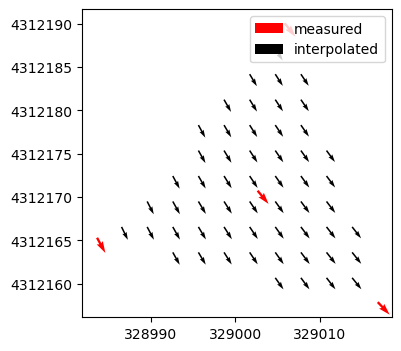

In [87]:
# we just have one density measurement at this height, so simply spread the
# measured density value across all the points
# rho_interp = np.full(u_interp.shape, src_3_c_density[i][0])

fig, ax = plt.subplots(figsize=(4,4))
ax.quiver(
    points_and_wind_fields.loc[10].x, 
    points_and_wind_fields.loc[10].y, 
    points_and_wind_fields.loc[10].u, 
    points_and_wind_fields.loc[10].v, 
    color='red', 
    label='measured'
)
ax.ticklabel_format(useOffset=False, style='plain')
ax.quiver(xx[:,:,3], yy[:,:,3], u_interp[:,:,3], v_interp[:,:,3], label='interpolated')
ax.ticklabel_format(useOffset=False, style='plain')
ax.legend(loc='upper right')

## 3D example

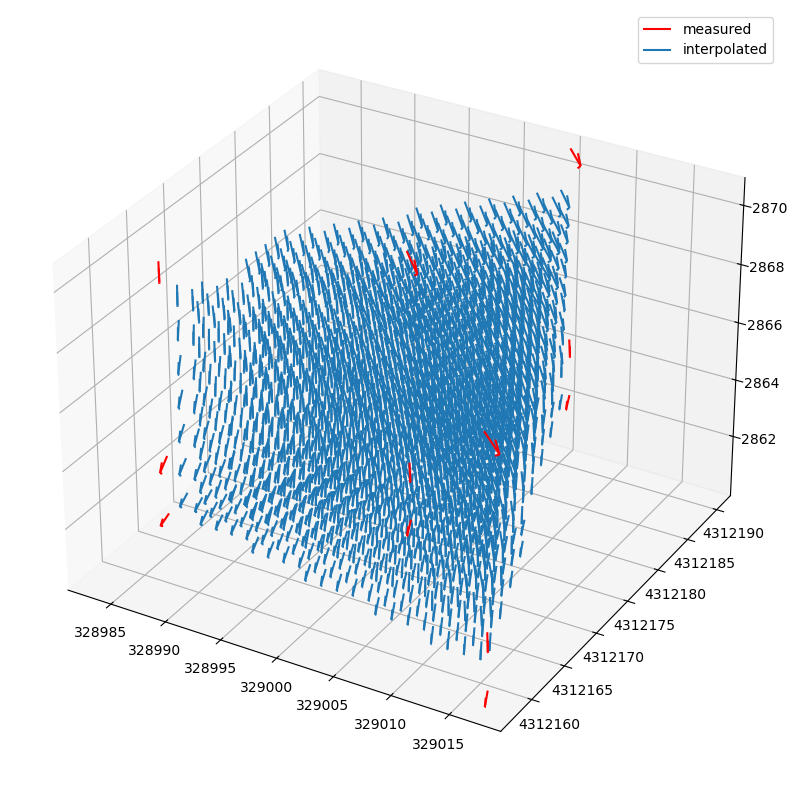

In [25]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

for i in [0]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.quiver(
        points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z, 
        points_and_wind_fields.u, points_and_wind_fields.v, points_and_wind_fields.w,
        color='red', label='measured', pivot='middle'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, zz, u_interp, v_interp, w_interp, label='interpolated', pivot='middle')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

## 3D divergence calculations (volumetric)

In [26]:
def divergence(f,sp):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [27]:
points_and_wind_fields.z.max() - points_and_wind_fields.z.min()

10.617400000000089

# SHOULD I TRY TO COMPARE THIS WITH THE WAY I PERSONALLY CALCULATE DIVERGENCE??

In [28]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
mean_divergences_lateral_bylayer = []
mean_divergences_vertical_bylayer = []
for i in wind_field_df.index:
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]

    
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
    mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))

assert len(wind_field_df) == len(mean_divergences)
windfield_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=wind_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1627094382.py:49: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1627094382.py:49: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52b

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/173837718.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/173837718.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/173837718.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


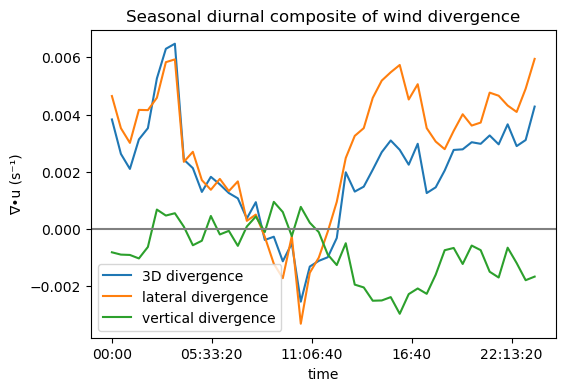

In [29]:
windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•u (s⁻¹)")
plt.title("Seasonal diurnal composite of wind divergence")
plt.legend()

In [30]:
src_lateral_bylayer = pd.DataFrame(mean_divergences_lateral_bylayer)
src_lateral_bylayer.index = wind_field_df.index

src_vertical_bylayer = pd.DataFrame(mean_divergences_vertical_bylayer)
src_vertical_bylayer.index = wind_field_df.index

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1113910705.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

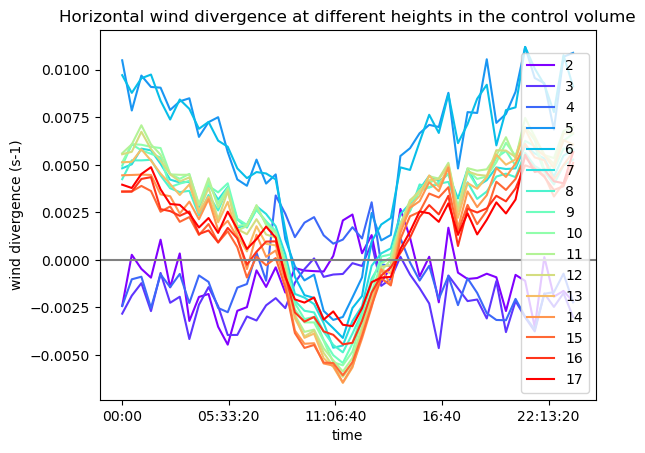

In [31]:
src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

In [32]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

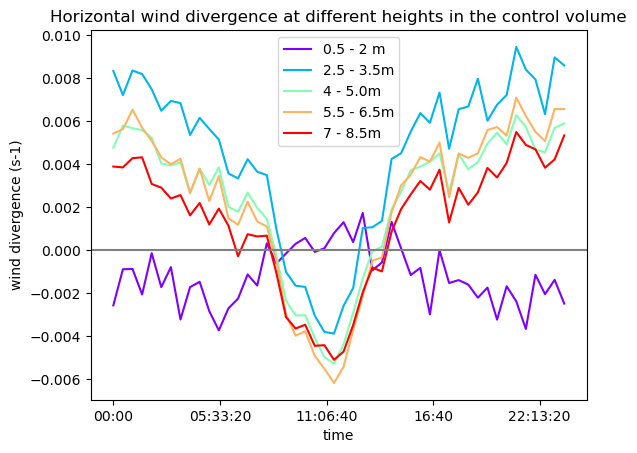

In [33]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/778491099.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Vertical wind divergence at different heights in the control volume')

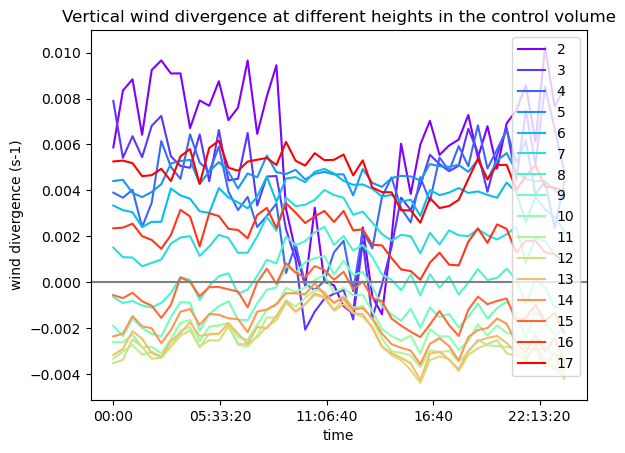

In [34]:
src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

In [35]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Vertical wind divergence at different heights in the control volume')

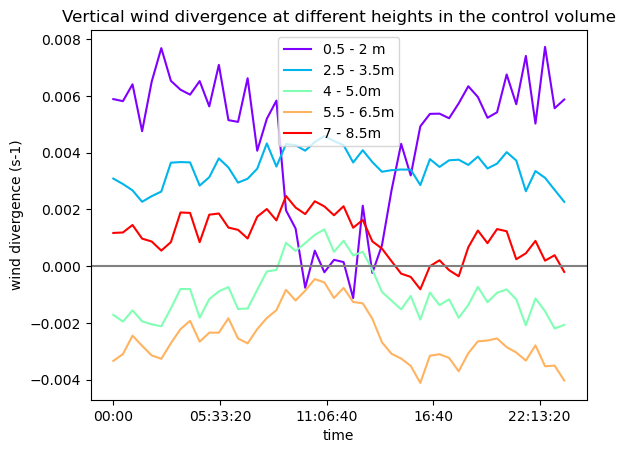

In [36]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

## 3D divergence calculations (advected water vapor)

### Using form: $\frac{\partial}{\partial x_i} (u_i q) $

In [37]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in adv_flux_field_df.index:
    adv_flux_field_vals = pd.DataFrame(adv_flux_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(adv_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(adv_flux_field_df) == len(mean_divergences)
adv_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=adv_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2068377316.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1853336912.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1853336912.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1853336912.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


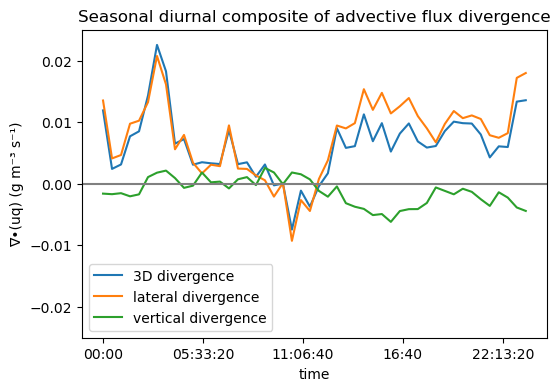

In [38]:
adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.ylim(-0.025,0.025)
plt.legend()

### Using form: $u_i  \frac{\partial}{\partial x_i} (q) $
NOTE: we also calculate a absolute humidity (Storage) time series in this loop

In [39]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
abs_humidity_mean = []
windfields = []
divergencefields = []
for i in abs_hum_field_df.index:
    # Get abs. humidity data
    abs_humidity_field_vals = pd.DataFrame(abs_hum_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)
    points_and_abs_humidity_field = x.join(y).join(z).join(abs_humidity_field_vals, how='right')

    # Get wind field data
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    # Create meshgrid
    xx = np.linspace(
        points_and_abs_humidity_field.x.min(), 
        points_and_abs_humidity_field.x.max(), 12
    )
    yy = np.linspace(
        points_and_abs_humidity_field.y.min(), 
        points_and_abs_humidity_field.y.max(), 12
    )
    zz = np.linspace(
        points_and_abs_humidity_field.z.min(), 
        points_and_abs_humidity_field.z.max(), 6
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)

    # Get points
    points = np.transpose(np.vstack((points_and_abs_humidity_field.x, points_and_abs_humidity_field.y, points_and_abs_humidity_field.z)))

    # Interpolate abs. humidity field
    abs_humidity_interp = interpolate.griddata(points, points_and_abs_humidity_field['Water vapor density'], (xx, yy, zz), method='linear')

    # Interpolate wind field
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    # Create wind-field 3D array
    F_windfield = np.array([u_interp, v_interp, w_interp])
    F_windfield_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_windfield_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]

    dq_over_dx = np.gradient(abs_humidity_interp, axis=0)
    dq_over_dy = np.gradient(abs_humidity_interp, axis=1)
    dq_over_dz = np.gradient(abs_humidity_interp, axis=2)
    g_lateral = u_interp * dq_over_dx + v_interp * dq_over_dy
    g_vertical = w_interp * dq_over_dz
    g = g_lateral + g_vertical
    divergencefields.append(g)
    windfields.append(F_windfield)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    abs_humidity_mean.append(np.nanmean(abs_humidity_interp))

assert len(abs_hum_field_df) == len(mean_divergences)
adv_flux_div_method2_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical,
        'absolute humidity': abs_humidity_mean
    }, 
    index=abs_hum_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:65: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:66: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:67: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:68: RuntimeWarning: Mean of empty slice
  abs_humidity_mean.append(np.nanmean(abs_humidity_interp))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:65: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/2226247383.py:66: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.a

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/399512506.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/399512506.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/399512506.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), l

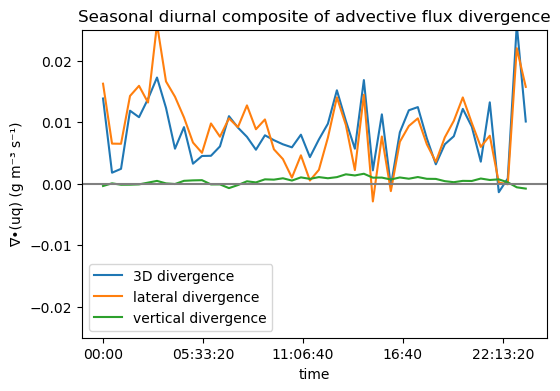

In [40]:
adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.ylim(-0.025,0.025)
plt.legend()

### Using form: $q \frac{\partial}{\partial x_i} (u_i) $
NOTE: we also calculate a absolute humidity (Storage) time series in this loop

In [41]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in abs_hum_field_df.index:
    # Get abs. humidity data
    abs_humidity_field_vals = pd.DataFrame(abs_hum_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)
    points_and_abs_humidity_field = x.join(y).join(z).join(abs_humidity_field_vals, how='right')

    # Get wind field data
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    # Create meshgrid
    xx = np.linspace(
        points_and_abs_humidity_field.x.min(), 
        points_and_abs_humidity_field.x.max(), 12
    )
    yy = np.linspace(
        points_and_abs_humidity_field.y.min(), 
        points_and_abs_humidity_field.y.max(), 12
    )
    zz = np.linspace(
        points_and_abs_humidity_field.z.min(), 
        points_and_abs_humidity_field.z.max(), 6
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)

    # Get points
    points = np.transpose(np.vstack((points_and_abs_humidity_field.x, points_and_abs_humidity_field.y, points_and_abs_humidity_field.z)))

    # Interpolate abs. humidity field
    abs_humidity_interp = interpolate.griddata(points, points_and_abs_humidity_field['Water vapor density'], (xx, yy, zz), method='linear')

    # Interpolate wind field
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    # Create wind-field 3D array
    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = abs_humidity_interp * divergence(F, sp)
    g_lateral = abs_humidity_interp * divergence(F_lateral, sp)
    g_vertical = abs_humidity_interp * divergence(F_vertical, sp)
    
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(abs_hum_field_df) == len(mean_divergences)
adv_flux_div_method3_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical,
    }, 
    index=abs_hum_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:57: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:58: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:59: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:57: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:58: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1205047972.py:59: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1743636054.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1743636054.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence_lateral.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/1743636054.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence_vertical.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4)

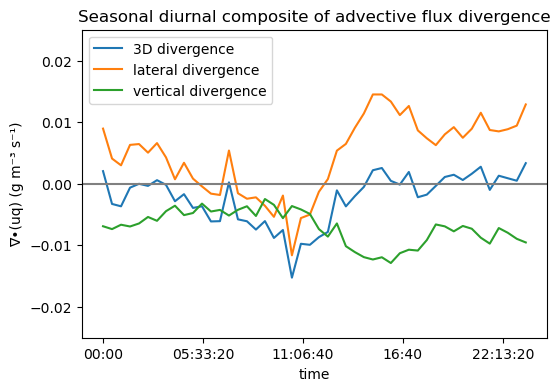

In [42]:
adv_flux_div_method3_df.mean_divergence.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method3_df.mean_divergence_lateral.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method3_df.mean_divergence_vertical.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.ylim(-0.025,0.025)
plt.legend()

## Check out the mean diurnal cycle in windfields!!!

In [43]:
windfield_ds = xr.DataArray(windfields)
div_fields_ds = xr.DataArray(divergencefields)

windfield_ds = windfield_ds.rename({
    'dim_0': 'time',
    'dim_1': 'variable',
    'dim_2': 'x',
    'dim_3': 'y',  
    'dim_4': 'z',  
})
div_fields_ds = div_fields_ds.rename({
    'dim_0': 'time',
    'dim_1': 'x',
    'dim_2': 'y',  
    'dim_3': 'z',  
})

windfield_ds = windfield_ds.assign_coords({'time': abs_hum_field_df.index})
div_fields_ds = div_fields_ds.assign_coords({'time': abs_hum_field_df.index})

windfield_ds = xr.Dataset({
    'u': windfield_ds[:, 0, :, :, :],
    'v': windfield_ds[:, 1, :, :, :],
    'w': windfield_ds[:, 2, :, :, :],
    'div': div_fields_ds
})

windfield_ds.coords['hourminute'] = (
    ('time', ),
    pd.MultiIndex.from_arrays([
        np.array(windfield_ds.time.dt.hour),
        np.array(windfield_ds.time.dt.minute)
    ])
)

windfield_mean_ds = windfield_ds.groupby('hourminute').mean(dim='time')
windfield_mean_nobs_ds = windfield_ds.sel(time=windfield_ds.time.isin(nobs_times)).groupby('hourminute').mean(dim='time')

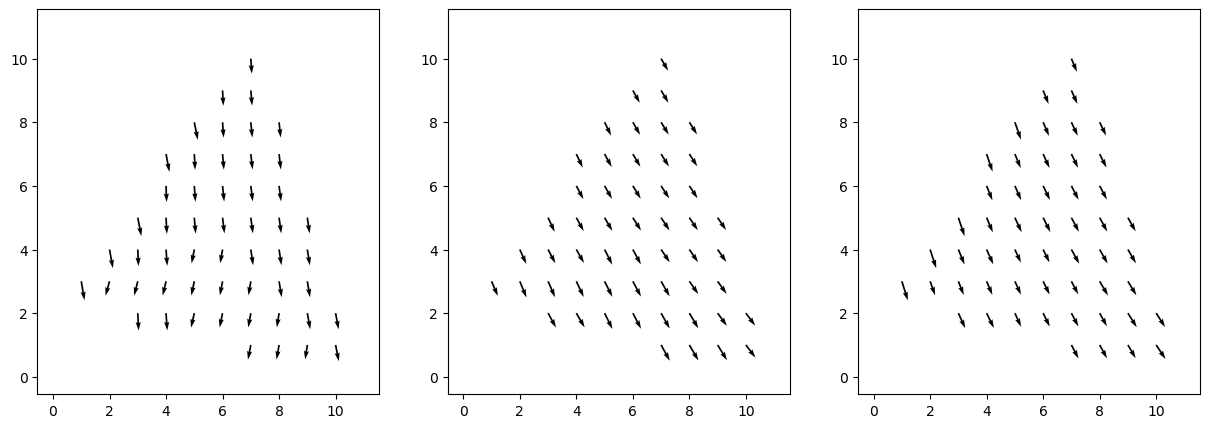

In [44]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].quiver(
    windfield_mean_ds.sel(hourminute=(10,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).v,
)
axes[1].quiver(
    windfield_mean_ds.sel(hourminute=(14,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).v,
)
axes[2].quiver(
    windfield_mean_ds.sel(hourminute=(22,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).v,
)

# HERE

In [58]:
# GET WIND FIELDS
src = wind_field_df[wind_field_df.index.isin(nobs_times)].groupby(
    wind_field_df[wind_field_df.index.isin(nobs_times)].index.floor('30T').time
).mean()
src = pd.DataFrame(src.loc[dt.time(14)]).reset_index()
src = src.pivot_table(index=['height','tower'], columns='measurement', values=dt.time(14, 0)).join(
    instrument_loc_df
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_48266/286292636.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  wind_field_df[wind_field_df.index.isin(nobs_times)].index.floor('30T').time


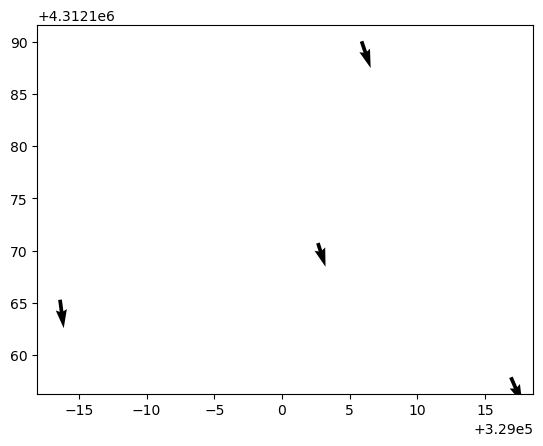

In [64]:
plt.quiver(src.loc[10].x, src.loc[10].y, src.loc[10].u, src.loc[10].v)

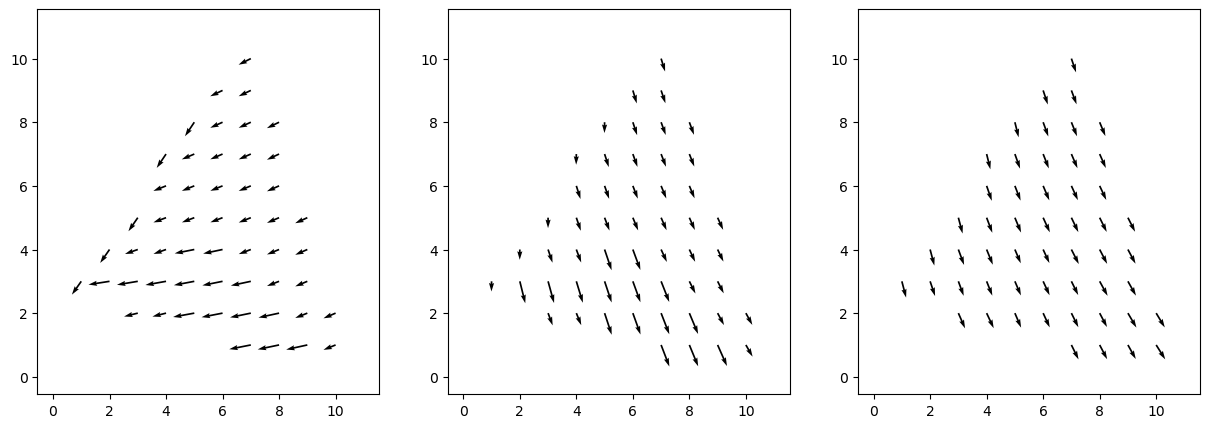

In [61]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).v,
)
axes[1].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).v,
)
axes[2].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).v,
)

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[0,0].quiver(
    windfield_ds.sel(time='20230202 0600', z=1).x,
    windfield_ds.sel(time='20230202 0600', z=1).y,
    windfield_ds.sel(time='20230202 0600', z=1).u,
    windfield_ds.sel(time='20230202 0600', z=1).v,
)
axes[0,1].quiver(
    windfield_ds.sel(time='20230202 1200', z=1).x,
    windfield_ds.sel(time='20230202 1200', z=1).y,
    windfield_ds.sel(time='20230202 1200', z=1).u,
    windfield_ds.sel(time='20230202 1200', z=1).v,
)
axes[0,2].quiver(
    windfield_ds.sel(time='20230202 2000', z=1).x,
    windfield_ds.sel(time='20230202 2000', z=1).y,
    windfield_ds.sel(time='20230202 2000', z=1).u,
    windfield_ds.sel(time='20230202 2000', z=1).v,
)
axes[1,0].quiver(
    windfield_ds.sel(time='20230202 0600', z=2).x,
    windfield_ds.sel(time='20230202 0600', z=2).y,
    windfield_ds.sel(time='20230202 0600', z=2).u,
    windfield_ds.sel(time='20230202 0600', z=2).v,
)
axes[1,1].quiver(
    windfield_ds.sel(time='20230202 1200', z=2).x,
    windfield_ds.sel(time='20230202 1200', z=2).y,
    windfield_ds.sel(time='20230202 1200', z=2).u,
    windfield_ds.sel(time='20230202 1200', z=2).v,
)
axes[1,2].quiver(
    windfield_ds.sel(time='20230202 2000', z=2).x,
    windfield_ds.sel(time='20230202 2000', z=2).y,
    windfield_ds.sel(time='20230202 2000', z=2).u,
    windfield_ds.sel(time='20230202 2000', z=2).v,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation,FFMpegWriter

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10,10))
ax.view_init(
    # elev=25, 
    # azim=-180, 
    # roll=0
)

def get_arrow(hourminute):
    """ hourminute should be something like (0,0) or (5, 30) or (21, 0)"""
    x = xx
    y = yy
    z = zz
    u = windfield_mean_nobs_ds['u'].sel(hourminute = hourminute)
    v = windfield_mean_nobs_ds['v'].sel(hourminute = hourminute)
    w = windfield_mean_nobs_ds['w'].sel(hourminute = hourminute)
    color = windfield_mean_nobs_ds['div'].sel(hourminute = hourminute)
    return x,y,z,u,v,w,color
x,y,z,u,v,w,color = get_arrow((0, 0))
c = (color.values.ravel() - np.nanmin(color)) / np.nanmax(color) - np.nanmin(color)
c = np.concatenate((c, np.repeat(c, 2)))
c.shape
c = plt.cm.jet(c)
# quiver = ax.quiver(x,y,z,u,v,w,colors=c)
quiver = ax.quiver(x,y,z,u,v,w)

ax.set_xlim(xx.min()-1, xx.max()+1)
ax.set_ylim(yy.min()-1, yy.max()+1)
ax.set_zlim(zz.min()-1, zz.max()+1)

def update(hourminute):
    global quiver
    quiver.remove()
    x,y,z,u,v,w,color = get_arrow(hourminute)
    c = (color.values.ravel() - np.nanmin(color)) / np.nanmax(color) - np.nanmin(color)
    c = np.concatenate((c, np.repeat(c, 2)))
    c.shape
    c = plt.cm.jet(c)
    # quiver = ax.quiver(x,y,z,u,v,w,colors=c)
    quiver = ax.quiver(x,y,z,u,v,w)
    ax.set_title(hourminute)

anim = FuncAnimation(
    fig, 
    update, 
    frames=sorted(windfield_mean_nobs_ds.hourminute.values),
    interval=250
)
plt.show()

In [ ]:
# Display animation with HTML
# video = anim.to_html5_video() # converting to an html5 video 
# html = display.HTML(video) # embedding for the video 
# display.display(html) # draw the animation 
# plt.close() 

# Save to file
writervideo = FFMpegWriter(fps=10) 
anim.save('increasingStraightLine.mp4', writer=writervideo) 
plt.close() 

In [ ]:
# for hrmin in windfield_mean_ds.hourminute:
#     fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10,10))
#     x = xx
#     y = yy
#     z = zz
#     u = windfield_mean_ds['u'].sel(hourminute = hrmin)
#     v = windfield_mean_ds['v'].sel(hourminute = hrmin)
#     w = windfield_mean_ds['w'].sel(hourminute = hrmin)
#     ax.quiver(*(x,y,z,u,v,w))
#     plt.show()

In [ ]:
adv_flux_div_method2_df['storage_change'] = (adv_flux_div_method2_df['absolute humidity']).diff() / (60*30)

In [ ]:
adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
adv_flux_div_method2_df.storage_change.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'storage change')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

## 3D divergence calculations (turb. diffused water vapor)

In [ ]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in turb_flux_field_df.index:
    turb_flux_field_vals = pd.DataFrame(turb_flux_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(turb_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u_h2o_, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v_h2o_, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w_h2o_, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(turb_flux_field_df) == len(mean_divergences)
turb_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=turb_flux_field_df.index
)

In [ ]:
turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of turbulent flux divergence")
plt.legend()

In [ ]:
display(turb_flux_div_df.head())
display(adv_flux_div_df.head())
display(adv_flux_div_method2_df.head())
display(windfield_div_df.head())

# Plot all results

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
VOLUME = A4*7*units('m')
A1, A2, A3, A4, A5, VOLUME

## Create combined dataset of all estimates

In [ ]:
 # advective_stuff = adv_flux_div_method2_df.rename(columns={
advective_stuff = adv_flux_div_df.rename(columns={
    "mean_divergence": 'total advective flux divergence',
    "mean_divergence_lateral": 'lateral advective flux divergence',
    "mean_divergence_vertical": 'vertical advective flux divergence',
})[[
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence',
    # 'storage_change'
]]
advective_stuff.index = pd.to_datetime(advective_stuff.index)

turbulent_stuff = turb_flux_div_df.rename(columns={
    'mean_divergence': 'total turbulent flux divergence',
    'mean_divergence_lateral': 'lateral turbulent flux divergence',
    'mean_divergence_vertical': 'vertical turbulent flux divergence',
})
turbulent_stuff.index = pd.to_datetime(turbulent_stuff.index)

winddiv_stuff = windfield_div_df.rename(columns={
    'mean_divergence': 'total wind divergence',
    'mean_divergence_lateral': 'lateral wind divergence',
    'mean_divergence_vertical': 'vertical wind divergence',
})
winddiv_stuff.index = pd.to_datetime(winddiv_stuff.index)

combo_df = advective_stuff.merge(
    turbulent_stuff, left_index=True, right_index=True
).merge(
    winddiv_stuff, left_index=True, right_index=True
)

# combo_df = combo_df[combo_df.index.isin(nobs_times)]

combo_df_area_norm = combo_df.copy(deep=True)
combo_df_area_norm = combo_df_area_norm * 7
combo_df_area_norm = combo_df_area_norm.join(
    tidy_df[
        tidy_df.variable.isin(
            ['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c']
        )
    ].pivot(index='time', columns='variable', values='value').reset_index().set_index('time')
)
combo_df_area_norm = combo_df_area_norm.reset_index()

In [ ]:
combo_df['storage_change'] = adv_flux_div_method2_df['storage_change']

## Plot divergences

In [ ]:
adv_flux_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

turb_flux_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total turbulent flux divergence',
    'lateral turbulent flux divergence',
    'vertical turbulent flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

storagechange_chart = alt.Chart(combo_df.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(storage_change):Q').title('Divergence (g/m^3/s)'),
).properties(width=150, height = 150)

(
    adv_flux_chart | turb_flux_chart | storagechange_chart
).resolve_scale(color='independent', y='shared').configure_legend(orient='right', columns=1)

In [ ]:
adv_flux_chart = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

turb_flux_chart = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'total turbulent flux divergence',
    'lateral turbulent flux divergence',
    'vertical turbulent flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

storagechange_chart = alt.Chart(combo_df_area_norm.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(storage_change):Q').title('Divergence (g/m^2/s)'),
).properties(width=150, height = 150)

vert_turb_flux_3m = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__10m_c',
    'w_h2o__20m_c'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

(
    adv_flux_chart | turb_flux_chart | storagechange_chart | vert_turb_flux_3m
).resolve_scale(color='independent', y='shared').configure_legend(orient='top', columns=1)

In [ ]:
wind_div_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total wind divergence',
    'lateral wind divergence',
    'vertical wind divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (1/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)
wind_div_chart

In [ ]:
alt.Chart(adv_flux_div_method2_df.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(absolute humidity):Q').title('Divergence (1/s)')
).properties(width=150, height = 150)

In [ ]:
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("w'q' (g/m^2/s)"),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['airdensity_3m_c', 'airdensity_10m_c', 'airdensity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['specifichumidity_3m_c', 'specifichumidity_10m_c', 'specifichumidity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
).resolve_scale(color='independent').configure_legend(orient='top').display(renderer='svg')

## Examine all terms in conservation of moisture eqxn

In [ ]:
combo_df_area_norm['source'] = combo_df_area_norm['storage_change'] + combo_df_area_norm['total advective flux divergence'] + combo_df_area_norm['total turbulent flux divergence']

In [ ]:
alt.Chart(
    combo_df_area_norm[(combo_df_area_norm.time > '20221221 1200') & (combo_df_area_norm.time < '20221223 1200')]
).transform_fold([
    'vertical advective flux divergence',
    'lateral advective flux divergence',
    'vertical turbulent flux divergence',
    'lateral turbulent flux divergence',
    'storage_change',
    'source'
]).mark_line().encode(
    alt.X('time:T').title('time of day'),
    alt.Y('value:Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N').title("term").sort([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ])
).properties(width=450, height = 300)

In [ ]:
def conservation_terms_plot(src):
    return alt.Chart(src).transform_fold([
        'total advective flux divergence',
        'total turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
        alt.Color('key:N').title("term")
    ).properties(width=150, height = 150)

def isin(df, list_of_timestamp_lists):
    if len(list_of_timestamp_lists) > 1:
        dates_intersection = [
            set(list_of_timestamp_lists[0]).intersection(l) for l in list_of_timestamp_lists[1:]
        ][0]
    else:
        dates_intersection = list_of_timestamp_lists[0]
    return df[df['time'].isin(dates_intersection)]

In [ ]:
(
    (
        conservation_terms_plot(combo_df_area_norm).properties(title='All data') |\
        conservation_terms_plot(isin(combo_df_area_norm, [nobs_times, is_not_snowing_dates])).properties(title='No BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [bs_times, is_not_snowing_dates])).properties(title='BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [is_snowing_dates])).properties(title='Is Snowing')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [december_times, nobs_times, is_not_snowing_dates])).properties(title='december (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [january_times, nobs_times, is_not_snowing_dates])).properties(title='january (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [february_times, nobs_times, is_not_snowing_dates])).properties(title='february (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [march_times, nobs_times, is_not_snowing_dates])).properties(title='march (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [april_times, nobs_times, is_not_snowing_dates])).properties(title='april (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 
    # & (
    #     conservation_terms_plot(isin(combo_df_area_norm, [december_times, bs_times, is_not_snowing_dates])).properties(title='december (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [january_times, bs_times, is_not_snowing_dates])).properties(title='january (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [february_times, bs_times, is_not_snowing_dates])).properties(title='february (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [march_times, bs_times, is_not_snowing_dates])).properties(title='march (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [april_times, bs_times, is_not_snowing_dates])).properties(title='april (BS, no snow)')
    # ).resolve_scale(x='shared', y='shared')
).configure_legend(orient='top').resolve_scale(x='shared', y='shared')

In [ ]:
def conservation_terms_plot(src):
    return alt.Chart(src).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=150, height = 150)

def isin(df, list_of_timestamp_lists):
    if len(list_of_timestamp_lists) > 1:
        dates_intersection = [
            set(list_of_timestamp_lists[0]).intersection(l) for l in list_of_timestamp_lists[1:]
        ][0]
    else:
        dates_intersection = list_of_timestamp_lists[0]
    return df[df['time'].isin(dates_intersection)]

In [ ]:
(
    (
        conservation_terms_plot(combo_df_area_norm).properties(title='All data') |\
        conservation_terms_plot(isin(combo_df_area_norm, [nobs_times, is_not_snowing_dates])).properties(title='No BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [bs_times, is_not_snowing_dates])).properties(title='BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [is_snowing_dates])).properties(title='Is Snowing')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [december_times, nobs_times, is_not_snowing_dates])).properties(title='December (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [january_times, nobs_times, is_not_snowing_dates])).properties(title='January (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [february_times, nobs_times, is_not_snowing_dates])).properties(title='February (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [march_times, nobs_times, is_not_snowing_dates])).properties(title='March (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [april_times, nobs_times, is_not_snowing_dates])).properties(title='April (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [midwinter_times, nobs_times, is_not_snowing_dates])).properties(title='Winter (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [spring_times, nobs_times, is_not_snowing_dates])).properties(title='Spring (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 
).configure_legend(orient='top').resolve_scale(x='shared', y='shared').display(renderer='svg')

In [ ]:
(
        conservation_terms_plot(isin(combo_df_area_norm, [midwinter_times, nobs_times, is_not_snowing_dates])).properties(title='Winter (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [spring_times, nobs_times, is_not_snowing_dates])).properties(title='Spring (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 


# Explore hypothesis that water gathers above surface, is drained away by drainage winds

Is there an along-valley gradient in water vapor? (From the SPLASH sites + ARM sites?).

I wonder if it sublimates during the day but just sits in a layer above the snow, and then gets “washed” down valley with the night winds?

In [ ]:
src = tidy_df[tidy_df.variable.isin(['SnowDepth_c', 'RH_1m_c'])].pivot_table(
    index='time',
    columns='variable',
    values = 'value'
).reset_index()
src['1m_instrument_height'] =  1 - src['SnowDepth_c']
src['time_of_day'] = src['time'].apply(lambda dt: 'night' if dt.hour in [18,19,20,21,22,23,1,2,3,4,5] else 'day')
src = src.set_index('time')
alt.Chart(src.reset_index()).mark_circle(size=10).encode(
    alt.X('1m_instrument_height'),
    alt.Y('RH_1m_c'),
    alt.Facet('time_of_day')
)

In [ ]:
src = tidy_df[tidy_df.variable.isin(['SnowDepth_c', 'RH_1m_c', 'specifichumidity_1m_c'])].pivot_table(
    index='time',
    columns='variable',
    values = 'value'
).reset_index()
src['1m_instrument_height'] =  1 - src['SnowDepth_c']
src['1m instrument height bins'] = pd.cut(
    src['1m_instrument_height'], 
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1], 
    labels = ['0.0 - 0.2', '0.2 - 0.4', '0.4 -  0.6', '0.6 - 0.8', '0.8 - 1']
)
src = src.set_index('time')
src = src.groupby([src.index.floor('30T').time, '1m instrument height bins'])[['RH_1m_c', 'specifichumidity_1m_c', 'SnowDepth_c', '1m_instrument_height']].mean().reset_index()
src['time_of_day'] = src['level_0'].apply(lambda tim: dt.datetime.combine(
    dt.datetime(2024, 2, 15),
    tim
))
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=300, height = 100) & 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T").axis(None),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=300, height = 100) & 
    (
        alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('specifichumidity_1m_c'),
            alt.Color('1m instrument height bins:O').scale(scheme='greys').title(['Instrument height above snow', '(Specific Humidity)']),
            # alt.StrokeDash('1m instrument height bins:O'),
        ) + alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('RH_1m_c'),
            alt.Color('1m instrument height bins:O').scale(scheme='blues').title(['Instrument height above snow', '(Relative Humidity)']),
            # alt.StrokeDash('1m instrument height bins:O'),
        )
    ).resolve_scale(y='independent', color='independent')
).resolve_scale(y='independent', color='independent')

In [ ]:
src1 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_1m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src1['instrument_height'] =  1 - src1['SnowDepth_c']
src1 = src1.rename(columns={'specifichumidity_1m_c': 'specifichumidity'})

src2 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_2m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src2['instrument_height'] =  2 - src2['SnowDepth_c']
src2 = src2.rename(columns={'specifichumidity_2m_c': 'specifichumidity'})

src3 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_3m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src3['instrument_height'] =  3 - src3['SnowDepth_c']
src3 = src3.rename(columns={'specifichumidity_3m_c': 'specifichumidity'})

src4 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_4m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src4['instrument_height'] =  4 - src4['SnowDepth_c']
src4 = src4.rename(columns={'specifichumidity_4m_c': 'specifichumidity'})

src5 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_5m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src5['instrument_height'] =  5 - src5['SnowDepth_c']
src5 = src5.rename(columns={'specifichumidity_5m_c': 'specifichumidity'})

src = pd.concat([src1,src2,src3,src4,src5])
bin_min = 0
bin_max = 5
steps = 26
src['instrument height bins'] = pd.cut(
    src['instrument_height'], 
    bins = np.linspace(bin_min, bin_max, steps), 
    labels = np.linspace(bin_min, bin_max, steps)[:-1] + 0.5*(bin_max/(steps-1))
)
src = src.set_index('time')
src = src.groupby([src.index.floor('30T').time, 'instrument height bins'])[['specifichumidity', 'SnowDepth_c', 'instrument_height']].mean().reset_index()
src['time_of_day'] = src['level_0'].apply(lambda tim: dt.datetime.combine(
    dt.datetime(2024, 2, 15),
    tim
))

(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=300, height = 100) & 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T").axis(None),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=300, height = 100) & 
    (
        alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('specifichumidity'),
            alt.Color('instrument height bins:O').scale(scheme='purpleorange').title(['Instrument height above snow', '(Specific Humidity)']),
            # alt.StrokeDash('instrument height bins:O'),
        )
    ).resolve_scale(y='independent', color='independent')
).resolve_scale(y='independent', color='independent')

In [ ]:
alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        # alt.Color('height:O').scale(scheme='greys'),
        alt.Color("month(time):O").sort(['Nov', 'Dec']).scale(scheme='turbo')
    ).properties(width=300, height = 100)

In [ ]:

windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')

In [ ]:
fig, axes = plt.subplots(3,1, sharex=True)
tidy_df.query("variable == 'SnowDepth_c'").set_index('time')['value'].plot(ax=axes[0])
tidy_df.query("variable == 'RH_1m_c'").set_index('time')['value'].plot(ax=axes[1])
plt.tight_layout()

In [ ]:
is_snowing_dates[is_snowing_dates.dt.month == 2].dt.day.unique()

In [ ]:
src = tidy_df[(tidy_df.time > '20230201') & (tidy_df.time < '20230204')]
# src = tidy_df[(tidy_df.time > '20221216') & (tidy_df.time < '20221221')]


In [ ]:
alt.Chart(
    src.query("variable == 'SnowDepth_d'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200, 
             title=f"Mean depth: {round(src.query("variable == 'SnowDepth_d'").value.mean(), 2)}m"
            )

In [ ]:
alt.Chart(
    src.query("variable == 'SnowDepth_c'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200, 
             title=f"Mean depth: {round(src.query("variable == 'SnowDepth_c'").value.mean(), 2)}m"
            )

In [ ]:
alt.Chart(
    src.query("variable == 'SF_avg_ue'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200)

In [ ]:
windstart_df = src.query("variable == 'Rsw_in_9m_d'")
windstart_df = windstart_df[(windstart_df.time.dt.hour == 9) & (windstart_df.time.dt.minute == 0)]
windend_df = src.query("variable == 'Rsw_in_9m_d'")
windend_df = windend_df[(windend_df.time.dt.hour == 15) & (windend_df.time.dt.minute == 30)]
(
    alt.Chart(windstart_df).mark_rule().encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule().encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.query("measurement == 'wind direction'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=800, height = 200)
).configure_axis(grid=False)

In [ ]:
sunrise_df = src.query("variable == 'Rsw_in_9m_d'")
sunrise_df = sunrise_df[(sunrise_df.time.dt.hour == 7) & (sunrise_df.time.dt.minute == 0)]
sunset_df = src.query("variable == 'Rsw_in_9m_d'")
sunset_df = sunset_df[(sunset_df.time.dt.hour == 17) & (sunset_df.time.dt.minute == 0)]
(
    alt.Chart(sunrise_df).mark_rule(color='yellow').encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='yellow').encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.query("variable == 'Rsw_in_9m_d'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Incoming Rsw (W/m^2)'),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=800, height = 200)
).configure_axis(grid=False)

In [ ]:
(        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'temperature'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Temperature (˚C)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(temperature)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent')

In [ ]:
hum_chart = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'specific humidity'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Specific humidity (g/g)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(specific humidity)'])
    ).properties(width=800, height = 200)
    +
    alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'RH'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Relative humidity (%)'),
        alt.Color("height:O").scale(scheme='reds').title(['Height','(relative humidity)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
    title='Relative and specific humidity measurements from tower C, height adjusted to snow depth'
)

In [ ]:
temp_chart = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
            pd.concat([
                src.assign(height = src.height - 0.88).query("measurement == 'snow temperature'").query("tower =='d'").query("height > 0.12"),
                src.assign(height = src.height - 0.66).query("measurement == 'temperature'").query("height > 0").query("height < 4")
            ])
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Temperature (˚C)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(temperature)']),
        tooltip='height'
    ).properties(width=800, height = 200)
).resolve_scale(
    y='independent', 
    color='independent',
).properties(
    title='Combined temperature measurements from tower D thermistors and tower C thermometers, height adjusted to snow depth'
)

In [ ]:
temp_chart & hum_chart 

In [ ]:
from metpy import calc
from metpy.units import units

In [ ]:
units.millibar

In [ ]:
w_w_ = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'w_w_'").query("height > 0").query("tower == 'c' ").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title("<w'w'> (m^2/s^2)"),
        alt.Color("height:O").scale(scheme='blues').title("Height (m)"),
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
)

In [ ]:
windspeed = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'wind speed'").query("height > 0").query("tower == 'c' ").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O").scale(scheme='blues').title(['Height (m)']),
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
)

In [ ]:
ri = (
    
alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
    src.assign(height = src.height - 0.66).query(
        "measurement == 'richardson number'"
    ).query("height > 0").query("tower == 'c' ").query("height < 4")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q").title("Ri").scale(type='symlog', domain=[-100,100], clamp=True).axis(values=[-1, -10, -100, 0.1, 1, 10, 100]),
    alt.Color("height:O").scale(scheme='blues'),
).properties(width=800, height = 200))

In [ ]:
airdensity = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + 
    alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'air density'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Air density (kg/m^3)').scale(zero=False),
        alt.Color("height:O").title(['Height (m)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
    
)

In [ ]:

(
    alt.Chart(
        combo_df_area_norm[(combo_df_area_norm.time > '20230201') & (combo_df_area_norm.time < '20230204')]
    ).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('time:T').title('time of day'),
        alt.Y('value:Q').title('Divergence (g/m^2/s)').scale(domain=[-0.2,0.2], clamp=True),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=800, height = 200)
    &
    temp_chart & hum_chart & airdensity.properties(height = 150
    ) & ri.properties(height = 150
    ) & windspeed.properties(height = 150
    ) & w_w_.properties(height = 150
    )).resolve_scale(color='independent', x='shared', y='independent')

In [ ]:
def month_series(src):
    return alt.Chart(
        src
    ).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('time:T').title('time of day'),
        alt.Y('value:Q').title('Divergence (g/m^2/s)').scale(domain=[-0.2,0.2], clamp=True),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=800, height = 200)

In [ ]:
month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20221201') & (combo_df_area_norm.time < '20221231')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230101') & (combo_df_area_norm.time < '20230131')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230201') & (combo_df_area_norm.time < '20230228')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230301') & (combo_df_area_norm.time < '20230331')]
)  & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230401') & (combo_df_area_norm.time < '20230430')]
)

In [ ]:
def scat(height_tower_str = '3m_c'):
    return alt.Chart(
        tidy_df[tidy_df.measurement.isin(['u','v'])].pivot(index='time', columns='variable', values='value').reset_index()
    ).mark_circle(color='black', size=1).encode(
        alt.X(f"u_{height_tower_str}:Q").scale(domain=[-6, 6], clamp=True), 
        alt.Y(f"v_{height_tower_str}:Q").scale(domain=[-6, 6], clamp=True)
    ).properties(width=150, height = 150)

In [ ]:
(scat('1m_c') | scat('2m_c') | scat('3m_c')| scat('5m_c') | scat('10m_c') | scat('15m_c')| scat('20m_c')).resolve_scale(x='shared', y='shared')

In [ ]:
(
    (scat('1m_c') & scat('3m_c') & scat('10m_c')).resolve_scale(x='shared', y='shared') |
    (scat('1m_d') & scat('3m_d') & scat('10m_d')).resolve_scale(x='shared', y='shared') |
    (scat('1m_ue') & scat('3m_ue') & scat('10m_ue')).resolve_scale(x='shared', y='shared') |
    (scat('1m_uw') & scat('3m_uw') & scat('10m_uw')).resolve_scale(x='shared', y='shared')   
).resolve_scale(x='shared', y='shared')

### Is there a consistent moisture gradient across our site?

In [ ]:
src

In [ ]:
# plot diurnal signal in gas analyzer abs. humidity measurements
src = tidy_df.query("measurement == 'Water vapor density'")
src = src[src.height.isin([3,10])]
src = src[src.time.isin(nobs_times)]
src = src[src.time.isin(is_not_snowing_dates)]
alt.Chart(
    src
).mark_line().encode(
    alt.X('hours(time):T'),
    alt.Y('mean(value):Q').title('Abs. humidity (g/m^3)').scale(zero=False),
    alt.Color("tower:N"),
    alt.StrokeDash('height:O')
).properties(
    title=['Composite (mean) diurnal cycle in humidity',
           'as measured by post-calibrated gas analyzers']
)

# Compare with results from the Control Volume approach

In [ ]:
cv_df = pd.read_csv('flux_divergence_3d_control_volume.csv').set_index('time')
cv_df.index = pd.to_datetime(cv_df.index)
cv_df.columns[-16:]

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_adv_divergence (g/s)'].plot()
adv_flux_div_df.groupby(adv_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
zz.max() - zz.min()

In [ ]:
cv_df.head()

In [ ]:

windfield_div_df